In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import logging

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [29]:
# Configuration
config = {
    "customer_file_path": "Customer_Feedback_Data.csv",
    "product_file_path": "Product_Offering_Data.csv",
    "transaction_file_path": "Transaction_Data.csv",
    # Number of clusters for K-Means
    "optimal_k": 3,  
}

In [13]:
# Function to load data
def load_data(file_path):
    """Load data from a CSV file."""
    try:
        data = pd.read_csv(file_path)
        logging.info(f"Data loaded successfully from {file_path}")
        return data
    except Exception as e:
        logging.error(f"Error loading data from {file_path}: {e}")
        raise

In [15]:
# Function to clean column names
def clean_column_names(df):
    """Clean column names by stripping whitespace, converting to lowercase, and replacing spaces with underscores."""
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    logging.info("Column names cleaned.")
    return df

In [17]:
# Function to handle missing data
def handle_missing_data(df, column, strategy='mean'):
    """Handle missing data in a column using the specified strategy."""
    if strategy == 'mean':
        df[column] = df[column].fillna(df[column].mean())
    elif strategy == 'mode':
        df[column] = df[column].fillna(df[column].mode()[0])
    elif strategy == 'unknown':
        df[column] = df[column].fillna('Unknown')
    logging.info(f"Missing data in column '{column}' handled using '{strategy}' strategy.")
    return df

In [19]:
# Function to normalize data
def normalize_data(df, column, scaler_type='minmax'):
    """Normalize data in a column using the specified scaler."""
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    df[f"{column}_scaled"] = scaler.fit_transform(df[[column]])
    logging.info(f"Column '{column}' normalized using '{scaler_type}' scaler.")
    return df

In [21]:
# Function to merge data
def merge_data(df1, df2, on_column, how='inner'):
    """Merge two DataFrames on a specified column."""
    merged_df = df1.merge(df2, on=on_column, how=how)
    logging.info(f"DataFrames merged on column '{on_column}'.")
    return merged_df

In [23]:
# Function to perform K-Means clustering
def perform_kmeans_clustering(data, features, n_clusters=3):
    """Perform K-Means clustering on the specified features."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['cluster'] = kmeans.fit_predict(data[features])
    logging.info(f"K-Means clustering performed with {n_clusters} clusters.")
    return data, kmeans

In [49]:
# Main function
def main():
    try:
        # Load data
        customer = load_data(config["customer_file_path"])
        product = load_data(config["product_file_path"])
        transaction = load_data(config["transaction_file_path"])

        # Clean column names
        customer = clean_column_names(customer)
        product = clean_column_names(product)
        transaction = clean_column_names(transaction)

        # Handle missing data
        customer = handle_missing_data(customer, 'satisfaction_score', strategy='mode')
        transaction = handle_missing_data(transaction, 'transaction_amount', strategy='mean')
        product = handle_missing_data(product, 'target_age_group', strategy='unknown')

        # Normalize transaction amount
        transaction = normalize_data(transaction, 'transaction_amount', scaler_type='minmax')

        # Merge transaction and product data
        if 'product_id' in transaction.columns and 'product_id' in product.columns:
            transaction = merge_data(transaction, product[['product_id', 'product_type']], on_column='product_id')
            transaction = handle_missing_data(transaction, 'product_type', strategy='unknown')
        else:
            logging.warning("'product_id' column not found in transaction or product data.")

        # Merge customer and transaction data for clustering
        clustering_data = merge_data(transaction[['customer_id', 'transaction_amount_scaled']],
                                     customer[['customer_id', 'satisfaction_score']],
                                     on_column='customer_id')

        # Perform K-Means clustering
        features = ['transaction_amount_scaled', 'satisfaction_score']
        clustering_data, kmeans = perform_kmeans_clustering(clustering_data, features, n_clusters=config["optimal_k"])

        # Visualize clusters
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='satisfaction_score', y='transaction_amount_scaled', hue='cluster', data=clustering_data, palette='viridis')
        plt.title('K-Means Clustering of Customers')
        plt.xlabel('Satisfaction Score')
        plt.ylabel('Scaled Transaction Amount')
        plt.show()

        # Evaluate clustering performance
        silhouette_avg = silhouette_score(clustering_data[features], clustering_data['cluster'])
        logging.info(f"Silhouette Score: {silhouette_avg}")

        # Save clustered data
        clustering_data.to_csv('clustered_customer_data.csv', index=False)
        logging.info("Clustered data saved to 'clustered_customer_data.csv'.")

    except Exception as e:
        logging.error(f"An error occurred: {e}")

2025-03-02 20:25:15,031 - INFO - Data loaded successfully from Customer_Feedback_Data.csv
2025-03-02 20:25:15,033 - INFO - Data loaded successfully from Product_Offering_Data.csv
2025-03-02 20:25:15,041 - INFO - Data loaded successfully from Transaction_Data.csv
2025-03-02 20:25:15,043 - INFO - Column names cleaned.
2025-03-02 20:25:15,045 - INFO - Column names cleaned.
2025-03-02 20:25:15,048 - INFO - Column names cleaned.
2025-03-02 20:25:15,051 - INFO - Missing data in column 'satisfaction_score' handled using 'mode' strategy.
2025-03-02 20:25:15,053 - INFO - Missing data in column 'transaction_amount' handled using 'mean' strategy.
2025-03-02 20:25:15,054 - INFO - Missing data in column 'target_age_group' handled using 'unknown' strategy.
2025-03-02 20:25:15,059 - INFO - Column 'transaction_amount' normalized using 'minmax' scaler.
2025-03-02 20:25:15,060 - WARNING - 'product_id' column not found in transaction or product data.
2025-03-02 20:25:15,065 - INFO - DataFrames merged on 

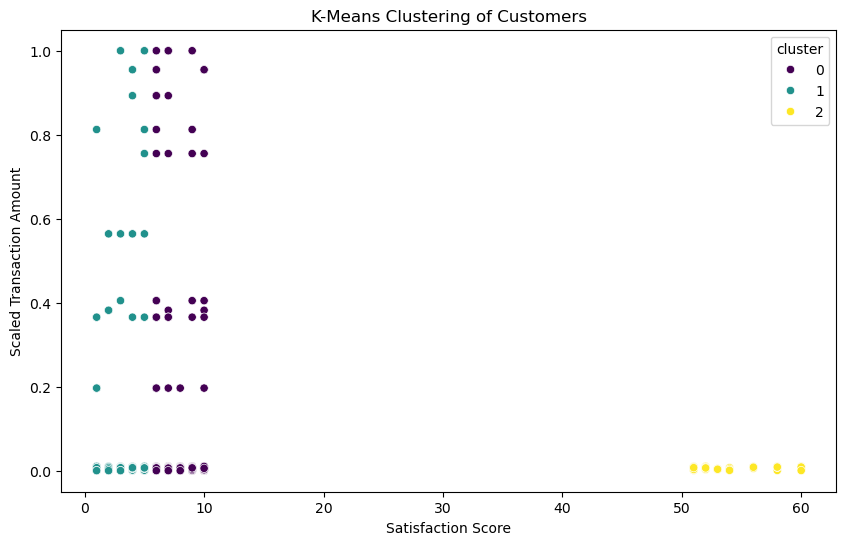

2025-03-02 20:25:22,594 - INFO - Silhouette Score: 0.6390316580749306
2025-03-02 20:25:22,630 - INFO - Clustered data saved to 'clustered_customer_data.csv'.


In [51]:
# Run the main function
if __name__ == "__main__":
    main()